# Machine Learning Demonstrations

In this notebook, we demonstrated how to use the Kx kdb+/q Automated Machine Learning library. The example below use samples from the Telco Customer Churn dataset.

<div class="alert alert-danger">
To run the below notebook, ensure that dependencies specified in <b>requirements.txt</b> have been correctly installed.
</div>

## Machine Learning Toolkit

The Machine Learning Toolkit ([ML-Toolkit](https://github.com/KxSystems/ml)) contains general use utilities, an implementation of the FRESH (Feature Extraction based on Scalable Hypothesis tests) algorithm and cross validation functions. The primary purpose of these libraries are to provide kdb+/q users with access to commonly-used ML functions for preprocessing data, extracting features and scoring results.

## Automated Machine Learning in kdb+/q

The kdb+/q [Automated Machine Learning](https://github.com/kxsystems/automl/) library is built largely on the tools available within the kdb+/q ML-Toolkit. The purpose of this library is to provide users with the ability to automate the process of applying machine learning techniques to real-world problems. In the absence of expert machine learning engineers this framework handles the following processes within a traditional workflow:

- Data preprocessing
- Feature engineering and feature selection
- Model selection
- Hyperparameter Tuning
- Report generation and model persistence

Each of these steps is outlined in depth within the documentation for this platform [here](https://code.kx.com/q/ml/automl). This allows users to understand the processes by which decisions are being made and the transformations which their data undergo during the production of the output models.

At present the supported machine learning problem types are classification and regression and based on:

- One-to-one feature to target non time-series
- FRESH based feature extraction and model production

The problems which can be solved by this framework will be expanded over time as will the available functionality.

### Multi-processing

This library supports multi-processed grid-search/cross-validation procedures and FRESH feature creation provided a user set `-s -8` in the JUPYTERQ_SERVERARGS, access to which can be found [here](https://code.kx.com/q/ml/jupyterq/notebooks/#server-command-line-arguments). In this demo, we use 8 worker processes and open a centralised port as below.

In [1]:
\p 5124

The Kx Automated Machine Learning library is then loaded in as follows:

In [2]:
// load in automl
\l automl/automl.q
.automl.loadfile`:init.q

Requirements for Keras models not satisfied. Keras and Tensorflow must be installed. Keras models will be excluded from model evaluation.


---

## Contents

Below, the notebook has been split into 3 distinct sections:
1. [Default Configurations](#Default-Configurations)
2. [Default NLP Configurations](#Default-NLP-Configurations)
3. [Custom Configurations (Advanced)](#Custom-Configurations-(Advanced))

---

## Default Configurations

### Telco Customer Churn

The [Telco Customer Churn dataset](https://www.kaggle.com/blastchar/telco-customer-churn/data) contains entries for 7043 customers. In each case below, we aim to create a model which can accurately predict customer churn based on 20 features relating to each customer.

Below we load in the data and select a subset of 5000 random data points to train and test the pipeline on. We also load in additional graphics and utility functions required throughout this notebook.

### Load data

In [3]:
// load utils
\l ../utils/util.q
\l ../utils/graphics.q

In [4]:
\S 42

// load data and separate into features and target
telcoData:5000?("SSBSSISSSSSSSSSSSSFFS";(),",")0:`:../data/telco.csv
telcoTarg:(`No`Yes!0 1)telcoData`Churn
telcoFeat:delete Churn from telcoData

// inspect data
-1"Shape of feature data is: ",(" x "sv string .ml.shape telcoFeat),"\n";
show 5#telcoFeat
-1"\nDistribution of target values:\n";
show update pcnt:round[;.01]100*num%sum num from select num:count i by target from([]target:telcoTarg);

Shape of feature data is: 5000 x 20

customerID gender SeniorCitizen Partner Dependents tenure PhoneService Multip..
-----------------------------------------------------------------------------..
5382-TEMLV Male   0             No      No         45     Yes          No    ..
5827-MWCZK Male   0             Yes     Yes        56     Yes          Yes   ..
3086-RUCRN Female 0             No      No         66     Yes          Yes   ..
5965-GGPRW Male   0             Yes     Yes        72     Yes          Yes   ..
2887-JPYLU Female 0             No      Yes        41     Yes          No    ..

Distribution of target values:

target| num  pcnt 
------| ----------
0     | 3637 72.74
1     | 1363 27.26


### Prepare data

As we want to run both `.automl.run` and `.automl.new` we start by splitting our data into a training and testing set, where 10% has been chosen for the testing set. Note that we have set a random seed so that results can be replicated.

In [5]:
\S 42
show telcoInputs:.ml.traintestsplit[telcoFeat;telcoTarg;.1]

xtrain| +`customerID`gender`SeniorCitizen`Partner`Dependents`tenure`PhoneServ..
ytrain| 0 0 1 0 1 0 1 1 1 0 1 0 0 0 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0..
xtest | +`customerID`gender`SeniorCitizen`Partner`Dependents`tenure`PhoneServ..
ytest | 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0..


### User Interface

At the highest level the automated machine learning library contains two primary callable functions:

- `.automl.run` = Run the automated machine learning pipeline on user defined data and target
- `.automl.new` = Using a previously fit model and set of instructions to produce an appropriate pipeline derived from a defined run, predict the target value for new tabular data

Both of these functions are modifiable by a user to suit specific use cases and have been designed to cover a wide range of functional options and to be extensible to a users needs.

### Inputs

Below we demonstrate how to apply `.automl.run` to our features and targets in the default setting, where the function has the syntax:

```.automl.run[tab;tgt;ftype;ptype;dict]```

Where:
- `tab` is unkeyed tabular data from which the models will be created
- `tgt` is the target vector
- `ftype` type of feature extraction being completed on the dataset as a symbol (``` `fresh```/``` `normal```)
- `ptype` type of problem, regression/class, as a symbol (``` `reg```/``` `class```)
- `dict` is one of `(::)` for default behaviour, a kdb+ dictionary or path to a user defined flat file for modifying default parameters.

In this case, we select ``` `normal``` feature extraction as we have a 1-to-1 mapping between features and targets. We also use ``` `class``` for the problem type as we are dealing with a binary classification problem.

**NB:** For the purposes of this demonstration we will pass in a dictionary in place of the default parameter `(::)`. In order to ensure replication for users of this notebook the random seed parameter ``` `seed``` is set in this example with the remaining parameters defaulted.

In [6]:
tab:telcoInputs`xtrain        / features
tgt:telcoInputs`ytrain        / targets
ftype:`normal                 / normal feature extraction
ptype:`class                  / classification problem
dict:enlist[`seed]!enlist 42  / default configuration

### Outputs

In the default configuration, the following items will be returned/saved during an individual run:

- The best model, saved as a hdf5 file for keras models, or "pickled" byte objects for sklearn models.
- A saved report indicating the procedure taken and scores achieved.
- A saved byte encoded dictionary denoting the procedure to be taken for reproducing results or running on new data.
- Results from each step of the pipeline published to console.

In addition to the saved outputs, the function will also return the date and time of the current run. This allows users to run the best model from a defined run on new data by passing the date and time to `.automl.new` (see example [below](#Test-on-new-data)).

We can now run `.aml.run` using the default setting with out training set from the Telco Customer Churn dataset.

In [7]:
start:.z.t
r1:.automl.run[tab;tgt;ftype;ptype;dict]
-1"\n.automl.run took ",string .z.t-start;


The following is a breakdown of information for each of the relevant columns in the dataset

                | count unique mean     std      min   max     type       
------          | --------------------------------------------------------
tenure          | 4500  73     32.326   24.55931 0i    72i     numeric    
MonthlyCharges  | 4500  1251   64.88498 30.49795 18.55 118.75  numeric    
TotalCharges    | 4500  3178   2284.252 2275.078 18.85 8672.45 numeric    
customerID      | 4500  3310   ::       ::       ::    ::      categorical
gender          | 4500  2      ::       ::       ::    ::      categorical
Partner         | 4500  2      ::       ::       ::    ::      categorical
Dependents      | 4500  2      ::       ::       ::    ::      categorical
PhoneService    | 4500  2      ::       ::       ::    ::      categorical
MultipleLines   | 4500  3      ::       ::       ::    ::      categorical
InternetService | 4500  3      ::       ::       ::    ::      categorical
Online

Saving down RandomForestClassifier model to /outputs/2020.09.22/run_10.42.20.254/models/
Saving down model parameters to /outputs/2020.09.22/run_10.42.20.254/config/

.automl.run took 00:00:41.812


#### Feature impact

<img src="images/run1impact.png" />

We see that in the above example, 8 features were passed to the model following the application of feature extraction and significance testing. 

**NB:** In the default case, normal feature extraction only uses the original features passed into the system, while FRESH feature extraction would apply the functions available for FRESH within the ML-Toolkit as defined by `.ml.fresh.params`.

Looking at the feature impact above, we can see that `tenure` had the highest feature impact in the dataset when applied to the best model.

#### Confusion matrix

<img src="images/run1conf.png" />

A confusion matrix is also produced within the pipeline for classification problems. We see that the final `RandomForestClassifier` model correctly classified 724 data points. 

All other outputs from this run have been stored in a directory of format `/outputs/date/run_time/`

### Test on new data

We can apply the workflow and fitted model associated with our specified run to new data using:

```.automl.new[tab;dt;tm]```

Where:

- `tab` is an unkeyed tabular dataset which has the same schema as the input data from the run specified in fpath
- `dt` is the date for a specified run as a date `yyyy.mm.dd` or a string of format `"yyyy.mm.dd"`
- `tm` is the timestamp for a specified run as a timestamp `hh:mm:ss.xxx` or a string of format `"hh:mm:ss.xxx"` or `"hh.mm.ss.xxx"` 

**NB:** Outputs from previous runs, such as `models` or `config`, are stored in the `outputs` directory and are organised such that we have the following file structure: `outputs/dt/run_tm/`, e.g. `outputs/2001.01.01/run_12.00.00.000"`.

The function will return the target predictions for new data based on the previously fitted model and workflow.

Below we apply `.automl.new` to the test set we created earlier and pass in the date and time of the previous run. This will apply the best model from the run above to our new data:

In [8]:
-1"Run applied to dataset:\n";
print_runid . r1;
-1"\nPredictions: ";
show pred:.automl.new[telcoInputs`xtest]. r1
-1"\nTargets:";
show telcoInputs`ytest

Run applied to dataset:

Run date: 2020.09.22. Run time: 10:42:20.254.

Predictions: 
0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 0..

Targets:
0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0..


We can see how the model performed using `.ml.accuracy`, used in the original default pipeline, and by producing a confusion matrix using `displayCM`:

In [9]:
-1"Accuracy on model run using hold-out data: ",string acc1:.ml.accuracy[telcoInputs`ytest;pred];

Accuracy on model run using hold-out data: 0.82


<Figure size 1440x1440 with 0 Axes>

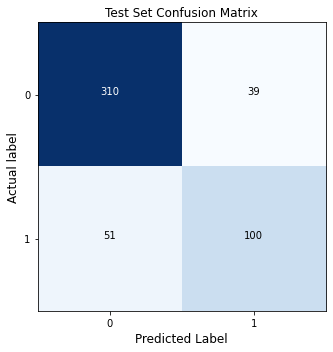

In [10]:
displayCM[value .ml.confmat[telcoInputs`ytest;pred];`0`1;"Test Set Confusion Matrix";()];

---

## Default NLP Configurations

The function `.automl.run` can also be applied to textual data using its default configuration.

As with the example above, data must be presented with a 1-to-1 mapping between features and targets.

NLP (Natural Language Processing) specific feature extraction is then applied to any character columns within the data using NLP methods contained within the Kx [NLP Library](https://github.com/KxSystems/nlp), while normal feature extraction is applied to any remaining features.

### IMBD Dataset

The [IMBD](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) dataset contains reviews of over 50,000 movies for NLP or text analytics. The dataset consists of 2 columns, containing textual reviews and their associated positive or negative sentiment classification.

### Load NLP data

Below we load in 1500 rows of the IMDB dataset.

In [11]:
// load data
imdbData:1500#("SI";enlist ",")0:`:../data/IMBD.csv

// convert text data to string
imdbData:update string each comment from imdbData

// separate into feature and target data
imdbFeat:select comment from imdbData
imdbTarg:imdbData`tgt

// inspect data
-1"Shape of feature data is: ",(" x "sv string .ml.shape imdbFeat),"\n";
show 5#imdbFeat
-1"\nDistribution of target values:\n";
show update pcnt:round[;.01]100*num%sum num from select num:count i by target from([]target:imdbTarg);

Shape of feature data is: 1500 x 1 x 585

comment                                                                        
-------------------------------------------------------------------------------
"If you like plot turns, this is your movie. It is impossible at any moment t..
"It's a real challenge to make a movie about a baby being devoured by wild ca..
"What a good film! Made Men is a great action movie with lots of twists and t..
"This is a movie that is bad in every imaginable way. Sure we like to know wh..
"There is something special about the Austrian movies not only by Seidl, but ..

Distribution of target values:

target| num pcnt 
------| ---------
0     | 740 49.33
1     | 760 50.67


We now split the data into training and testing sets to be used with `.automl.run` and `.automl.new`.

In [12]:
show imdbInputs:.ml.traintestsplit[imdbFeat;imdbTarg;.1]

xtrain| +(,`comment)!,("Three years ago, Rachel(Therese Fretwell) was partyin..
ytrain| 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 1 1..
xtest | +(,`comment)!,("CAROL'S JOURNEY is a pleasure to watch for so many re..
ytest | 1 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1..


### Inputs

The below example demonstrates a binary classification problem. Notice that this time `nlp` is being passed as the feature extraction type.

The default configuration for AutoML will again be used, with a random seed included so that results can be replicated.

In [13]:
tab:imdbInputs`xtrain          / features
tgt:imdbInputs`ytrain          / targets
ftype:`nlp                     / NLP feature extraction
ptype:`class                   / classification problem
dict:enlist[`seed]!enlist 168  / default configuration

### Outputs

We can now run `automl.run` utilizing the NLP functionality.

<div class="alert alert-danger">
<b>Warning</b>: Please allow ample time for the NLP configuration to run as feature extraction and hyperparameter search can take upwards of 5 minutes to complete.
</div>

In [14]:
start:.z.t
r2:.automl.run[tab;tgt;ftype;ptype;dict]
-1"\n.automl.run took ",string .z.t-start;


The following is a breakdown of information for each of the relevant columns in the dataset

       | count unique mean std min max type
-------| ----------------------------------
comment| 1350  1350   ::   ::  ::  ::  text

Data preprocessing complete, starting feature creation

Feature creation and significance testing complete
Starting initial model selection - allow ample time for large datasets

Total features being passed to the models = 88

Scores for all models, using .ml.accuracy
MLPClassifier             | 0.7963302
RandomForestClassifier    | 0.7951942
GradientBoostingClassifier| 0.7789488
LinearSVC                 | 0.7720191
KNeighborsClassifier      | 0.7662522
AdaBoostClassifier        | 0.7592889
SVC                       | 0.7546108
LogisticRegression        | 0.7523189
GaussianNB                | 0.6921562

Best scoring model = MLPClassifier
Score for validation predictions using best model = 0.7731481


Feature impact calculated for features associated with MLPClas

#### Feature impact

<img src="images/run2impact.png" />

From the above example, we can see that even though one feature was passed to the model, multiple features were created using the `nlp` feature creation methods. If there was any additional non textual data present, the `normal` feature creation procedures would of been applied to them. 

Looking at the feature impact above, we can see that the features created by the `word2vec` module (`colx`) were deemed to be the most important 

#### Confusion matrix

<img src="images/run2conf.png" />

A confusion matrix is also produced within the pipeline for classification problems. We see that the final `MLPClassifier` model correctly classified 284 data points. 

All other outputs from this run have been stored in a directory of format `/outputs/date/run_time/`

### Test on new data

The best model created within `automl.run` , is applied to the unseen test data to evaluate the models performance

In [15]:
-1"Run applied to dataset:\n";
print_runid . r2;
-1"\nPredictions: ";
show imdbIred:.automl.new[imdbInputs`xtest]. r2
-1"\nTargets:";
show imdbInputs`ytest

Run applied to dataset:

Run date: 2020.09.22. Run time: 10:43:03.002.

Predictions: 
1 0 0 0 0 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1..

Targets:
1 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 0 1 1 1..


In [16]:
-1"Accuracy on model run using hold-out data: ",string acc2:.ml.accuracy[imdbInputs`ytest;imdbPred];

Accuracy on model run using hold-out data: 0.6933333


<Figure size 1440x1440 with 0 Axes>

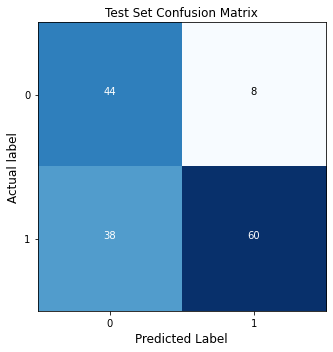

In [17]:
displayCM[value .ml.confmat[imdbInputs`ytest;imdbPred];`0`1;"Test Set Confusion Matrix";()];

---

## Custom Configurations (Advanced)

In the previous section of the notebook, we showcased how to apply default parameters within the pipeline (excluding the random seed). In this section we will focus on how the final parameter of `.automl.run` can be modified to apply changes to the default behaviour.

There are two options for how this final parameter can be input:
- **kdb+ dictionary** outlining the changes to default behaviour that are to be made
- The path to a **flat file** containing more human readable configuration updates.

### Advanced parameters

The following lists the parameters which can be altered by users to modify the functionality of the automl platform. In each case, the parameter name corresponds to the kdb+ dictionary key which would be passed, alongside its user defined value, to the `.automl.run` function in order to update functionality.

Parameters:

```txt
aggcols     Aggregation columns for FRESH
funcs       Functions to be applied for feature extraction
gs          Grid search function and no. of folds/percentage of data in validation set
hld         Size of the testing set on which the final model is tested
hp          Type of hyperparameter search to perform - `grid`random`sobol
rs          Random search function and no. of folds/percentage of data in validation set
saveopt     Saving options outlining what is to be saved to disk from a run
scf         Scoring functions for classification/regression tasks
seed        Random seed to be used
sigfeats    Feature significance procedure to be applied to the data
sz          Size of validation set used.
trials      Number of random/Sobol-random hyperparameters to generate
tts         Train-test split function to be applied
xv          Cross-validation function and # of folds/percentage of data in validation set
```

### Example 1

In this case we use the Telco dataset and alter the parameter dictionary `p` in the following ways:
1. Added a **random seed**: Here we have altered the ``` `seed``` parameter to be `75`.
2. Added **feature extraction**: As mentioned above, in the default setting no functions are applied to the table during feature extraction. Below we apply `.automl.prep.i.truncsvd` to the data, this is a truncated singular value decomposition outlined [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) and applied to all combinations of columns of type float.
3. Changed the size of the **testing** and **holdout** sets to be 10% of the data at each stage.
4. Changed the **hyperparameter search** type from the default of grid search to random search. Note that Sobol-random search is also available.

In [18]:
show p:`seed`funcs`sz`hld`hp!(75;`.automl.prep.i.truncsvd;.1;.1;`random)

seed | 75
funcs| `.automl.prep.i.truncsvd
sz   | 0.1
hld  | 0.1
hp   | `random


In [19]:
start:.z.t
r3:.automl.run[telcoInputs`xtrain;telcoInputs`ytrain;`normal;`class;p]
-1"\n.automl.run took ",string .z.t-start;


The following is a breakdown of information for each of the relevant columns in the dataset

                | count unique mean     std      min   max     type       
------          | --------------------------------------------------------
tenure          | 4500  73     32.326   24.55931 0i    72i     numeric    
MonthlyCharges  | 4500  1251   64.88498 30.49795 18.55 118.75  numeric    
TotalCharges    | 4500  3178   2284.252 2275.078 18.85 8672.45 numeric    
customerID      | 4500  3310   ::       ::       ::    ::      categorical
gender          | 4500  2      ::       ::       ::    ::      categorical
Partner         | 4500  2      ::       ::       ::    ::      categorical
Dependents      | 4500  2      ::       ::       ::    ::      categorical
PhoneService    | 4500  2      ::       ::       ::    ::      categorical
MultipleLines   | 4500  3      ::       ::       ::    ::      categorical
InternetService | 4500  3      ::       ::       ::    ::      categorical
Online

Saving down RandomForestClassifier model to /outputs/2020.09.22/run_10.48.53.629/models/
Saving down model parameters to /outputs/2020.09.22/run_10.48.53.629/config/

.automl.run took 00:14:38.024


<img src="images/run3impact.png" />

We can see by looking at the feature impact that many of the most impactful features are now derived from those generated when `.automl.prep.i.truncsvd` was applied during feature extraction, this gives some insight into the potential benefit of this form of feature extraction. 

While benefiting from increases in accuracy the addition of larger numbers of features can have the effect of slowing training time and scoring time which have have an impact in time critical use-cases.

We can now predict on the hold-out dataset in order to compare accuracy results to the default case.

In [20]:
-1"Run applied to dataset:\n";
print_runid . r3;
-1"\nPredictions: ";
show pred:.automl.new[telcoInputs`xtest]. r3
-1"\nTargets:";
show telcoInputs`ytest

Run applied to dataset:

Run date: 2020.09.22. Run time: 10:48:53.629.

Predictions: 
0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0..

Targets:
0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0..


In [21]:
print_runid . r1;
-1"Accuracy on default model run using held-out data: ",string[acc1],"\n";
print_runid . r3;
-1"Accuracy on custom model run using held-out data : ",string .ml.accuracy[telcoInputs`ytest;pred];

Run date: 2020.09.22. Run time: 10:42:20.254.
Accuracy on default model run using held-out data: 0.82

Run date: 2020.09.22. Run time: 10:48:53.629.
Accuracy on custom model run using held-out data : 0.826


We can see that by adding feature extraction in the normal case we have improved our accuracy by ~ 8%. This is highlighted in the confusion matrix below.

<Figure size 1440x1440 with 0 Axes>

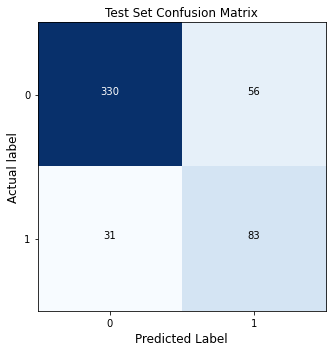

In [22]:
displayCM[value .ml.confmat[telcoInputs`ytest;pred];`0`1;"Test Set Confusion Matrix";()];

### Example 2

In this example we again use the Telco dataset and highlight how to change the save options, contained under `saveopt` within the parameter dictionary.

In the default case, not modified in the examples above, the system will save all outputs to disk (reports, images, config file and models). This can be altered by the user to reduce the number of outputs saved to disk, where:

- `0` = Nothing is saved the models will run and display results to console but nothing persisted
- `1` = Save the model and configuration file only, will not generate a report for the user or any images
- `2` = Save all possible outputs to disk for the user including reports, images, config and models

We demonstrate the case for `0` below for a subset of 1000 data points.

In [23]:
\S 42
feat:1000?telcoFeat
targ:1000?telcoTarg

In [24]:
.automl.run[feat;targ;`normal;`class;enlist[`saveopt]!enlist 0];


The following is a breakdown of information for each of the relevant columns in the dataset

                | count unique mean     std      min   max     type       
------          | --------------------------------------------------------
tenure          | 1000  73     33.551   25.0546  0i    72i     numeric    
MonthlyCharges  | 1000  582    64.02735 30.38511 18.8  118.75  numeric    
TotalCharges    | 1000  834    2358.61  2345.948 18.85 8672.45 numeric    
customerID      | 1000  842    ::       ::       ::    ::      categorical
gender          | 1000  2      ::       ::       ::    ::      categorical
Partner         | 1000  2      ::       ::       ::    ::      categorical
Dependents      | 1000  2      ::       ::       ::    ::      categorical
PhoneService    | 1000  2      ::       ::       ::    ::      categorical
MultipleLines   | 1000  3      ::       ::       ::    ::      categorical
InternetService | 1000  3      ::       ::       ::    ::      categorical
Online

As we can see compared to the previous default behaviour nothing has been saved down during a single run of the pipeline.

### Example 3

In this example, the IMDB dataset is used with the following changes made to the input dictionary `p`:

1. **Word2vec transformation** changed from default `continuous bag of words` method to `skip-gram`.
2. **Significant feature function** changed to use the Benjamini-Hochberg-Yekutieli procedure.
3. **Random seed** set as `100`.

In [25]:
// new significant feature function 
.automl.newsigfeat:{[x;y]
  .ml.fresh.significantfeatures[x;y;.ml.fresh.benjhoch 0.05]
  }

// new parameter dictionary
show p:`sigfeats`w2v`seed!(`.automl.newsigfeat;1;150)

sigfeats| `.automl.newsigfeat
w2v     | 1
seed    | 150


In [26]:
// run automl with new parameters
r4:.automl.run[imdbInputs`xtrain;imdbInputs`ytrain;`nlp;`class;p]


The following is a breakdown of information for each of the relevant columns in the dataset

       | count unique mean std min max type
-------| ----------------------------------
comment| 1350  1350   ::   ::  ::  ::  text

Data preprocessing complete, starting feature creation

Feature creation and significance testing complete
Starting initial model selection - allow ample time for large datasets

Total features being passed to the models = 222

Scores for all models, using .ml.accuracy
MLPClassifier             | 0.800941
LinearSVC                 | 0.7951606
RandomForestClassifier    | 0.7858986
GradientBoostingClassifier| 0.7719855
AdaBoostClassifier        | 0.7604181
LogisticRegression        | 0.7384527
SVC                       | 0.7326926
KNeighborsClassifier      | 0.7118228
GaussianNB                | 0.6805753

Best scoring model = MLPClassifier
Score for validation predictions using best model = 0.8518519


Feature impact calculated for features associated with MLPClas

We can see that the features deemed important compared with the initial run have varied. In this iteration, some of the features that were created from the NLP parser such as `CARDINAL` and compound were identified as significant in predicting the target value

<img src="images/run4impact.png" />

In [27]:
print_runid . r4;
-1"\nPredictions: ";
show pred:.automl.new[imdbInputs`xtest]. r4
-1"\nTargets:";
show imdbInputs`ytest

Run date: 2020.09.22. Run time: 11:04:09.318.

Predictions: 
0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0..

Targets:
1 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 0 1 1 1..


In [28]:
print_runid . r2;
-1"Accuracy on default model run using held-out data: ",string[acc2],"\n";
print_runid . r2;
-1"Accuracy on custom model run using held-out data : ",string .ml.accuracy[imdbInputs`ytest;imdbPred];

Run date: 2020.09.22. Run time: 10:43:03.002.
Accuracy on default model run using held-out data: 0.6933333

Run date: 2020.09.22. Run time: 10:43:03.002.
Accuracy on custom model run using held-out data : 0.6933333


### Example 4

We have shown in the previous examples that the pipeline can be altered by passing in a dictionary of parameters as the last argument in `.automl.run`. As mentioned previously, we can also pass the path to a flat file.

Default flat files are saved to `automl/code/models/` where users can change parameters within each file. These are generated by a user using the function `.automl.savedefault` as follows:

In [28]:
.automl.savedefault["new_normal_defaults.txt";`normal]

[0;31mThis file already exists.[0m: [0;31mThis file already exists.[0m

We can then run the pipeline using this new file as our final argument:

In [29]:
.automl.run[telcoFeat;telcoTarg;`normal;`class;"new_normal_defaults.txt"];


The following is a breakdown of information for each of the relevant columns in the dataset

                | count unique mean     std      min   max     type       
------          | --------------------------------------------------------
tenure          | 5000  73     32.2504  24.55779 0i    72i     numeric    
MonthlyCharges  | 5000  1285   64.82904 30.46505 18.55 118.75  numeric    
TotalCharges    | 5000  3413   2281.232 2279.37  18.85 8672.45 numeric    
customerID      | 5000  3566   ::       ::       ::    ::      categorical
gender          | 5000  2      ::       ::       ::    ::      categorical
Partner         | 5000  2      ::       ::       ::    ::      categorical
Dependents      | 5000  2      ::       ::       ::    ::      categorical
PhoneService    | 5000  2      ::       ::       ::    ::      categorical
MultipleLines   | 5000  3      ::       ::       ::    ::      categorical
InternetService | 5000  3      ::       ::       ::    ::      categorical
Online

Saving down RandomForestClassifier model to /outputs/2020.09.22/run_11.11.29.264/models/
Saving down model parameters to /outputs/2020.09.22/run_11.11.29.264/config/


---